# This notebook trains autoencoders and RBMs and save the encoded data of original images. No edge detection is applied!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') # mount google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!pip install pycm livelossplot   # install the package for live plotting
%pylab inline

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 552kB 6.9MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# import necessary libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset 
import torchvision.transforms as transforms


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Load Images

In [ ]:
!unzip -q "/content/gdrive/My Drive/acse9/data/Reg50_Cropped_npy.zip"  # quitely unzip image files folder

In [ ]:
import torchvision.datasets as datasets
from torch.autograd import Variable
import os
from os.path import join as pjoin
from PIL import Image

In [ ]:
def load_train_data(data_dir):
  """
  Load the data under the data directory
  """
  all_images = []
  for i in os.listdir(data_dir):
    img_path = pjoin(data_dir, i) 
    img_list = np.load(img_path)
    for j in range(len(img_list)):
        all_images.append(img_list[j])

  return all_images

In [ ]:
all_images = load_train_data("./Reg50_Cropped_npy") # get all images for training 

In [ ]:
print(len(all_images)) # print the number of images

7434


In [ ]:
size = np.array(all_images).shape[1] # get the size of the image
print(size)

100


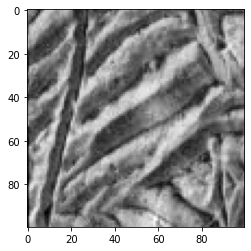

In [ ]:
plt.imshow(all_images[0],cmap='gray')

# Create training and validation dataset

In [ ]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
# identify hyperparameters
all_images = np.array(all_images)/255  # normalize images 
seed = 42
batch_size = 256
test_batch_size = 256
learning_rate = 1e-3
num_epochs = 50

split_rate = 0.1 # the percentage of validation set

s1 = np.random.choice(range(len(all_images)), int(len(all_images)*split_rate), replace=False)  # validation set indices
s2 = list(set(range(len(all_images))) - set(s1))   # train set indices

print(len(s2))

# create train data loader
X_train = all_images[s2]
y_train = np.zeros(len(all_images[s2]))
train_set = CustomImageTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4) #create dataloader

# create validation set data loader
X_validate = all_images[s1]
y_validate = np.zeros(len(all_images[s1]))
validation_set = CustomImageTensorDataset(torch.from_numpy(X_validate).float(), torch.from_numpy(y_validate).long())
validation_loader = DataLoader(validation_set, batch_size=test_batch_size, shuffle=True, num_workers=4) #create dataloader

# create full dataloader
X_full = all_images
y_full = np.zeros(len(all_images))
full_set = CustomImageTensorDataset(torch.from_numpy(X_full).float(), torch.from_numpy(y_full).long())
full_loader = DataLoader(full_set, batch_size=batch_size, shuffle=True, num_workers=4) #create dataloader


6691


# the class for creating Autoencoder models

In [ ]:
def get_output_shape(model, image_dim):
    """
    This function is able to get the dimension of outputs after a few convolution layers

    Attribute: 
    model : the model to inspect the dimension of outputs during training
    image_dim : the inputs of data to this model
    """
  return model(torch.rand(*(image_dim))).data.shape


class autoencoder(nn.Module):
  """
  this class is able to generate a convolutional autoencoder model that compress the image to a specified dimension-number (encoding_dim)
  
  """
  def __init__(self,input_dim,encoding_dim):  # encoding_dim: the size after encoding , input_dim : the size before encoding
    super(autoencoder,self).__init__()
    self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, stride=2, padding=1),nn.PReLU(),nn.GroupNorm(16,16),nn.PReLU(),nn.Dropout(p=0.2))
    self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=2, padding=1),nn.PReLU(),nn.GroupNorm(32,32),nn.PReLU(),nn.Dropout(p=0.2))
    self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 7),nn.PReLU(),nn.GroupNorm(64,64),nn.PReLU())
      
    self.num_shape_after_cnn1 = get_output_shape(self.enc1,input_dim)   # get the dimension after the first layer 
    self.num_shape_after_cnn2 = get_output_shape(self.enc2,self.num_shape_after_cnn1) # get the dimension after the second layer
    self.num_shape_after_cnn3 = get_output_shape(self.enc3,self.num_shape_after_cnn2)  # get the dimension after the third layer

    self.num_shape_after_cnn_final = self.num_shape_after_cnn3       # the dimension after the convolutional layers of encoder part

    self.num_features_before_fcnn = np.prod(list(self.num_shape_after_cnn_final)) # flatten
    print(self.num_features_before_fcnn)
    self.fc1 = nn.Sequential(nn.Linear(in_features=self.num_features_before_fcnn, out_features=encoding_dim),nn.PReLU(),nn.Dropout(p=0.2))
    self.fc2 = nn.Sequential(nn.Linear(in_features=encoding_dim, out_features=self.num_features_before_fcnn),nn.PReLU(),nn.Dropout(p=0.2))

    self.dec1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 7),nn.PReLU(),nn.GroupNorm(32,32),nn.PReLU())

    self.dec2 = nn.Sequential(nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),nn.PReLU(),nn.GroupNorm(16,16),nn.PReLU(),nn.Dropout(p=0.2))

    self.dec3 = nn.Sequential(nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),nn.Sigmoid())

        
  def encode(self,x):
    x = self.enc1(x)
    x = self.enc2(x)
    x = self.enc3(x)

    x = x.view(-1,self.num_features_before_fcnn) # flatten 
    x = self.fc1(x)
    return x
    
  def decode(self,x):
    x = self.fc2(x)
    self.num_shape_after_cnn_final = np.array(self.num_shape_after_cnn_final) # convert to numpy array
    x = x.view(-1,self.num_shape_after_cnn_final[1],self.num_shape_after_cnn_final[2],self.num_shape_after_cnn_final[3]) # reshape to feed into the encoder 
    x = self.dec1(x)
    x = self.dec2(x)
    x = self.dec3(x)

    return x


  def forward(self,x):
    # encoding
    x = self.encode(x)       
    # decoding
    x = self.decode(x)
    return x
    
  def sparse_loss(self,x):
    """
    This function adds L1 regularization to MSE loss
    """
    loss = 0
    # encoder
    x = self.enc1(x)
    loss += torch.mean(torch.abs(x))
    x = self.enc2(x)
    loss += torch.mean(torch.abs(x))

    x = self.enc3(x)
    loss += torch.mean(torch.abs(x))

    x = x.view(-1,self.num_features_before_fcnn) # flatten 
    x = self.fc1(x)
    loss += torch.mean(torch.abs(x))

    # decoder
    x = self.fc2(x)
    loss += torch.mean(torch.abs(x))
    self.num_shape_after_cnn_final = np.array(self.num_shape_after_cnn_final) # convert to numpy array
    x = x.view(-1,self.num_shape_after_cnn_final[1],self.num_shape_after_cnn_final[2],self.num_shape_after_cnn_final[3]) # reshape to feed into the encoder 

    x = self.dec1(x)
    loss += torch.mean(torch.abs(x))

    x = self.dec2(x)
    loss += torch.mean(torch.abs(x))

    x = self.dec3(x)
    loss += torch.mean(torch.abs(x))
  
    return loss

# Create directory to save models

In [ ]:
model_base_dir = os.path.join('/content/gdrive/My Drive/acse9/models','autoencoders_no_edge')
if not os.path.exists(model_base_dir):
        os.mkdir(model_base_dir)
else:
    print('Directory exists!')

Directory exists!


# Training and Validation Functions

In [ ]:
def train_epoch(model,optimizer,criterion,train_data_loader,add_sparsity=False,reg_parameter=0,penalty_type='L1',denoising=False,NOISE_FACTOR=0):
    """
    This function trains the model for one epoch. By setting the parameter add_sparsity to True, the autoencoder becomes a sparse autoencoder;
    and if denoising is set to True, the autoencoder becomes a denoising autoencoder

    Attribute:
    reg_parameter: the regularization parameter of sparsity
    NOISE_FACTOR: how much noise are added to input if is a denoising autoencoder
    """
    running_loss_train = 0.0
    model.train()
    for data in train_data_loader:
        img,_ = data
        img = img.to(device)
        img_noisy = (img.cpu().numpy() + NOISE_FACTOR * (torch.randn(img.shape).cpu().numpy())) # add noise to the image data
        img = img.view(img.size(0),1,size,size)

    # if the autoencoder is not a denoising autoencoder
        if denoising==False:
            l1_loss = model.sparse_loss(img)
            img = Variable(img) # wrap the tensor for training
            output = model(img)
            mse_loss = criterion(output,img)
         
            
        else: # if the autoencoder is a denoising autoencoder
            img_noisy = torch.from_numpy(np.clip(img_noisy, 0., 1.)).float().to(device) # clip to make the values fall between 0 and 1
            img_noisy = img_noisy.view(img_noisy.size(0),1,size,size)
            l1_loss = model.sparse_loss(img_noisy)

            img_noisy = Variable(img_noisy) # wrap the tensor for training
            output = model(img_noisy)
            mse_loss = criterion(output,img)

        if add_sparsity == True:
            if penalty_type == 'L1':
                loss = mse_loss + reg_parameter*l1_loss
        else:
            loss = mse_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss_train+=mse_loss*img.size(0)  # add the losses
    return running_loss_train/len(train_data_loader.dataset)  # average the losses

In [ ]:
def validate_epoch(model,optimizer,criterion,validation_data_loader,add_sparsity=False,reg_parameter=0,penalty_type='L1',denoising=False,NOISE_FACTOR=0):
    """
    This function evaluate the model on validation set, set add_sparsity to True, if you are training a sparse autoencoder; set denoising to True, if you are training a validation autoencoder
    Attributes:
    reg_parameter: the regularization parameter of sparsity
    NOISE_FACTOR: how much noise are added to input if is a denoising autoencoder
    """

    running_loss_val = 0.0
    model.eval()
    for data in validation_data_loader:
        with torch.no_grad():
            img,_ = data
            img = img.to(device)
            img_noisy = (img.cpu().numpy() + NOISE_FACTOR * (torch.randn(img.shape).cpu().numpy())) # add noise to the image data
            img = img.view(img.size(0),1,size,size)

        # if the autoencoder is not a denoising autoencoder
            if denoising==False:
                img = Variable(img) # wrap the tensor for training
                output = model(img)
                mse_loss_val = criterion(output,img)
                 
            else: # if the autoencoder is a denoising autoencoder
                img_noisy = torch.from_numpy(np.clip(img_noisy, 0., 1.)).float().to(device) # clip to make the values fall between 0 and 1
                img_noisy = img_noisy.view(img_noisy.size(0),1,size,size)
                img_noisy = Variable(img_noisy) # wrap the tensor for training
                output = model(img_noisy)
                mse_loss_val = criterion(output,img)

            running_loss_val+=mse_loss_val*img.size(0) 

    return running_loss_val/len(validation_data_loader.dataset)

In [ ]:
def fit(model,optimizer,criterion,train_data_loader,validation_data_loader,num_epochs, add_sparsity=False,reg_parameter=0,penalty_type='L1',rho=0,beta=0,denoising=False,NOISE_FACTOR=0,model_name='autoencoder_test'):
    """
    This function is for the full training and validation process. set add_sparsity to True, if you are training a sparse autoencoder; set denoising to True, if you are training a validation autoencoder
    Attributes:
    
    reg_parameter: the regularization parameter of sparsity
    NOISE_FACTOR: how much noise are added to input if is a denoising autoencoder

    """
    
    min_val_loss = 2.0 # initialize minimum validation loss
    min_epoch_num = 0  # initialize the epoch number when the minimum validation loss is achieved
    liveloss = PlotLosses()

    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        logs = {}
        train_loss = train_epoch(model,optimizer,criterion,train_data_loader,add_sparsity=add_sparsity,reg_parameter=reg_parameter,penalty_type=penalty_type,rho=rho,beta=beta,denoising=denoising,NOISE_FACTOR=NOISE_FACTOR)
        validation_loss = validate_epoch(model,optimizer,criterion,validation_data_loader,add_sparsity=add_sparsity,reg_parameter=reg_parameter,penalty_type=penalty_type,rho=rho,beta=beta,denoising=denoising,NOISE_FACTOR=NOISE_FACTOR)

        logs['' + 'log loss'] = train_loss.item()
        training_losses.append(train_loss.item())
        logs['val_' + 'log loss'] = validation_loss.item()
        validation_losses.append(validation_loss.item())
    #Store the best validation loss model
        if validation_loss < min_val_loss:
            dir = os.path.join(model_base_dir,'{}.pth'.format(model_name))
            torch.save(model.state_dict(), dir)
            min_val_loss = validation_loss
            min_epoch_num = epoch+1    # we need epoch number = min_epoch_num to achieve the minimum validation loss

        liveloss.update(logs)
        liveloss.draw()
    
    print('At epoch [{}/{}], get minimum validation loss: {:.4f}'.format(min_epoch_num,num_epochs,min_val_loss))
    return training_losses, validation_losses

# Instantiate Autoencoder models and training

# Training Basic Autoencoder

In [ ]:
encoding_dim = 100
set_seed(seed)
input_dim = (1,1,size,size) # get the tuple of input dimension 
model_auto = autoencoder(input_dim,encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_auto.parameters(),lr=learning_rate,weight_decay=1e-3)
#noise_factor = 0.5

23104


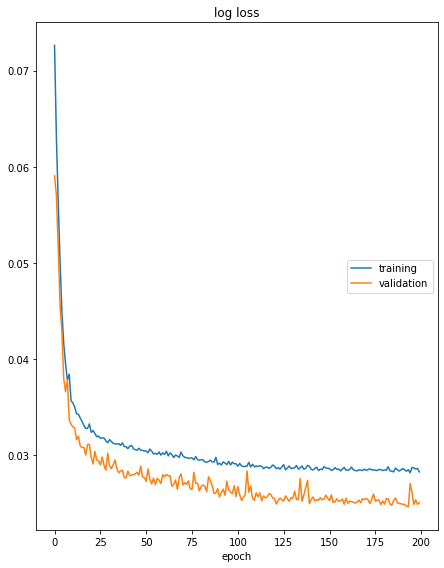

log loss
	training         	 (min:    0.028, max:    0.073, cur:    0.028)
	validation       	 (min:    0.025, max:    0.059, cur:    0.025)
At epoch [194/200], get minimum validation loss: 0.0246


In [ ]:
num_epochs = 200
basic_autoencoder_training_losses,basic_autoencoder_validation_losses = fit(model_auto,optimizer,criterion,train_loader,validation_loader,num_epochs,model_name = 'basic_autoencoder')

# Training Denosing Autoencoder

In [ ]:
encoding_dim = 100
set_seed(seed)
input_dim = (1,1,size,size) # get the tuple of input dimension 
model_auto = autoencoder(input_dim,encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_auto.parameters(),lr=learning_rate,weight_decay=1e-3)

23104


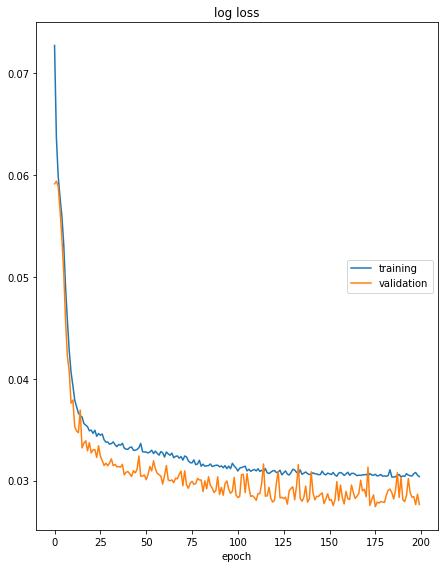

log loss
	training         	 (min:    0.030, max:    0.073, cur:    0.030)
	validation       	 (min:    0.027, max:    0.059, cur:    0.028)
At epoch [176/200], get minimum validation loss: 0.0274


In [ ]:
num_epochs = 200
denoising_autoencoder_training_losses,denoising_autoencoder_validation_losses = fit(model_auto,optimizer,criterion,train_loader,validation_loader,num_epochs,denoising=True,NOISE_FACTOR=0.5,model_name = 'denoising_autoencoder_0_5')

# Training Sparse Autoencoder

In [ ]:
encoding_dim = 100
set_seed(seed)
input_dim = (1,1,size,size) # get the tuple of input dimension 
model_auto = autoencoder(input_dim,encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_auto.parameters(),lr=learning_rate,weight_decay=1e-3)

23104


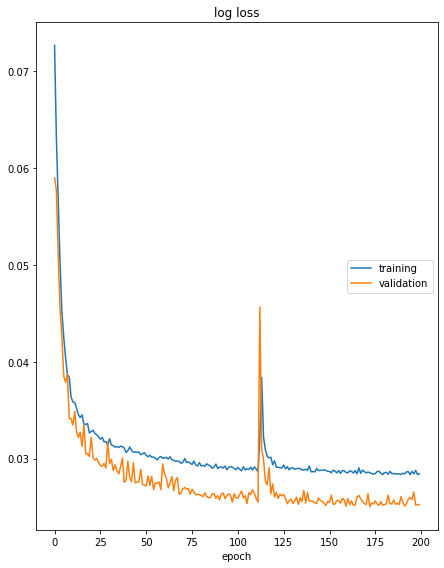

log loss
	training         	 (min:    0.028, max:    0.073, cur:    0.028)
	validation       	 (min:    0.025, max:    0.059, cur:    0.025)
At epoch [173/200], get minimum validation loss: 0.0250


In [ ]:
num_epochs = 200
sparse_autoencoder_training_losses,sparse_autoencoder_validation_losses = fit(model_auto,optimizer,criterion,train_loader,validation_loader,num_epochs,add_sparsity=True,reg_parameter=0.001,model_name = 'sparse_autoencoder_0_001')

# Comparison between autoencoders.Combine log loss plots into one single figure

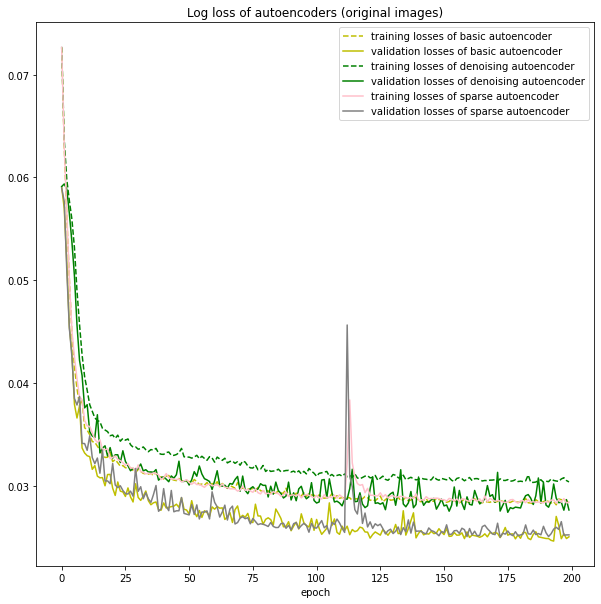

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(0,200),basic_autoencoder_training_losses,'y--',label = 'training losses of basic autoencoder')
plt.plot(range(0,200),basic_autoencoder_validation_losses,'y-',label = 'validation losses of basic autoencoder')
plt.plot(range(0,200),denoising_autoencoder_training_losses,'g--',label = 'training losses of denoising autoencoder')
plt.plot(range(0,200),denoising_autoencoder_validation_losses,'g-',label = 'validation losses of denoising autoencoder')
plt.plot(range(0,200),sparse_autoencoder_training_losses,'pink',label = 'training losses of sparse autoencoder')
plt.plot(range(0,200),sparse_autoencoder_validation_losses,'gray',label = 'validation losses of sparse autoencoder')
plt.title('Log loss of autoencoders (original images)')
plt.xlabel('epoch')
plt.legend()

# Make directory to store the encoded data

In [ ]:
encoded_base_dir = os.path.join('/content/gdrive/My Drive/acse9/data','encoded_data_no_edge')
if not os.path.exists(encoded_base_dir):
        os.mkdir(encoded_base_dir)
        print('Finish creating the directory to store the encoded data.')
else:
    print('Directory exists!')

Finish creating the directory to store the encoded data.


# Get Encoded Array from those autoencoder models

In [ ]:
def get_encoded_array(model,data_loader,batch_num,is_full=True):
  """
  Use this to extract encoded images from pre-trained auto-encoder model
  ----------------------------------------------------------------------
  Parameters:
    model: auto_encoder model for dimension reduction
    data_loader: source data to encode
    batch_num: number of batches needed for reducing dimension
    is_full: boolean value to determine whether we want all the data to be encoded

  return:
    encoded array
  """
  encoded_array = []
  model.eval()  # set the auto-encoder model to evaluation mode
  eval_loss = 0.0
  cnt = 0
  with torch.no_grad():
      for data in data_loader:
          img, label = data
          img = img.to(device)
          img = img.view(img.size(0),1,-1,size)
          img = Variable(img)
          #label = Variable(label)
          out = model.encode(img)
        
          if(cnt==0):
            encoded_array = out.detach().cpu().numpy() # initialize the encoded array with the first batch
          if ((is_full == False) and (cnt == (batch_num -1))):
            break
          if(cnt!=0):
            encoded_array = np.concatenate((encoded_array,out.detach().cpu().numpy()),axis = 0)
          cnt+=1
  return encoded_array

In [ ]:
model_base_dir = os.path.join('/content/gdrive/My Drive/acse9/models','autoencoders_no_edge') # get the path to save the basic autoencoder model
if not os.path.exists(model_base_dir):
    print('Error! The directory does not exist!')

In [ ]:
!ls '/content/gdrive/My Drive/acse9/models/autoencoders_no_edge'      # list all models we have collected

basic_autoencoder.pth	       sparse_autoencoder_0_001.pth
denoising_autoencoder_0_5.pth


In [ ]:
def model_extract_encoded_data(dataloader,model_name='basic_autoencoder',encoding_dim=100,input_size = 100):
    """
    This function are used to obtain the encoded data from different models
    Attributes:
    dataloader: the data to extract features
    model_name: the model used to extract features
    input_size : the size of input images
    encoding_dim: the dimension of latent representation
    """
    input_dim = (1,1,input_size,input_size)
    load_path = os.path.join(model_base_dir,'{}.pth'.format(model_name))
    model = autoencoder(input_dim,encoding_dim).to(device)
    model.load_state_dict(torch.load(load_path))
    encoded_array = get_encoded_array(model,full_loader,2,True) # get the encoded array for clustering
    return encoded_array

# Save the latent representation extracted by Basic model

In [ ]:
encoded_array_basic_model = model_extract_encoded_data(full_loader)
np.savez_compressed('/content/gdrive/My Drive/acse9/data/encoded_data_no_edge/encoded_data_basic_autoencoder.npz', data=encoded_array_basic_model,original_image=all_images,edge=edges)

23104


# Save the latent representation extracted by Denoising Autoencoder

In [ ]:
encoded_array_denoising_model_05 = model_extract_encoded_data(full_loader,model_name = 'denoising_autoencoder_0_5')
np.savez_compressed('/content/gdrive/My Drive/acse9/data/encoded_data_no_edge/encoded_data_denoising_autoencoder_0_5.npz', data=encoded_array_denoising_model_05,original_image =all_images,edge=edges)

23104


# Save the latent representation extracted by Sparse Autoencoder

In [ ]:
encoded_array_sparse_model_0001 = model_extract_encoded_data(full_loader,model_name = 'sparse_autoencoder_0_001')
np.savez_compressed('/content/gdrive/My Drive/acse9/data/encoded_data_no_edge/encoded_data_sparse_autoencoder_0_001.npz', data=encoded_array_sparse_model_0001,original_image=all_images,edge=edges)

23104


# Training RBM: RBM does not converge. So for original images, we did not save the compressed data (RBMs only accept binary inputs, however original images have continuous values.)

In [ ]:
from sklearn.neural_network import BernoulliRBM  #import module

In [ ]:
# check input are beween 0-1
print(all_images.min())
print(all_images.max())

0.00784313725490196
1.0


In [ ]:
# identify hyperparameters
seed = 42
batch_size = 200
learning_rate = 2e-3
num_epochs = 200

In [ ]:
model_rbm = BernoulliRBM(n_components=100,learning_rate=learning_rate,batch_size=batch_size,n_iter=num_epochs,random_state=seed,verbose=1) # n_components symbolize the size after dimension reduction 

X = all_images  # already been normalized to [0,1]
X = X.reshape(-1,size*size)

RBM = model_rbm.fit(X)  # the training of RBM does not converge

KeyboardInterrupt: ignored

#Training Stacked RBMs: training does not converge. So we didn't save the compressed data of original images. (RBMs only accept binary inputs, however original images have continuous values.)

In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
# inspired by https://stackoverflow.com/questions/52166308/stacking-rbms-to-create-deep-belief-network-in-sklearn

In [ ]:
# check input are between 0-1
print(all_images.min())
print(all_images.max())


0.00784313725490196
1.0


In [ ]:
# identify hyperparameters
seed = 42
batch_size = 128
learning_rate = 1e-3
num_epochs = 100

In [ ]:
"""
Stack four layers of RBM, each layer has a decreasing number of components
"""
rbm1 = BernoulliRBM(n_components=5000,learning_rate=learning_rate,batch_size=batch_size,n_iter=num_epochs,random_state=seed,verbose=1) # n_components symbolize the size after dimension reduction 
rbm2 = BernoulliRBM(n_components=2000, learning_rate=learning_rate, batch_size=batch_size,n_iter=num_epochs,random_state=seed,verbose=1)
rbm3 = BernoulliRBM(n_components=1000, learning_rate=learning_rate, batch_size=batch_size,n_iter=num_epochs,random_state=seed,verbose=1)
rbm4 = BernoulliRBM(n_components=100, learning_rate=learning_rate, batch_size=batch_size,n_iter=num_epochs,random_state=seed,verbose=1)

DBN3 = Pipeline(steps=[('rbm1', rbm1),('rbm2', rbm2), ('rbm3', rbm3),('rbm4',rbm4)])

X = edges  # already been normalized to [0,1]
X = X.reshape(-1,size*size)  # flatten

RBM = DBN3.fit(X)  # train the stacked RBMs model: does not converge, So we abort the execution


[BernoulliRBM] Iteration 1, pseudo-likelihood = -6862.55, time = 115.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -6869.99, time = 139.68s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -6872.26, time = 139.73s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -6874.15, time = 139.64s


KeyboardInterrupt: ignored